### EDA

**Импорт библиотек**

In [1]:
# !pip install squarify

In [2]:
# !pip install spacy

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
import re

In [7]:
from collections import Counter

In [8]:
import squarify

In [9]:
import nltk

In [10]:
from nltk.corpus import stopwords

In [11]:
from nltk.tokenize import word_tokenize

In [12]:
from nltk.stem import WordNetLemmatizer

In [13]:
import spacy

In [14]:
from wordcloud import WordCloud

In [15]:
from nltk import ngrams

**Загружаем предобработанные данные**

In [16]:
df = pd.read_parquet('df2.parquet')

Признаков у нас нет, поэтому мы можем произвести только базовый текстовый анализ.

**Анализ таргета**

_Вывод._ Таргет распределен поровну:

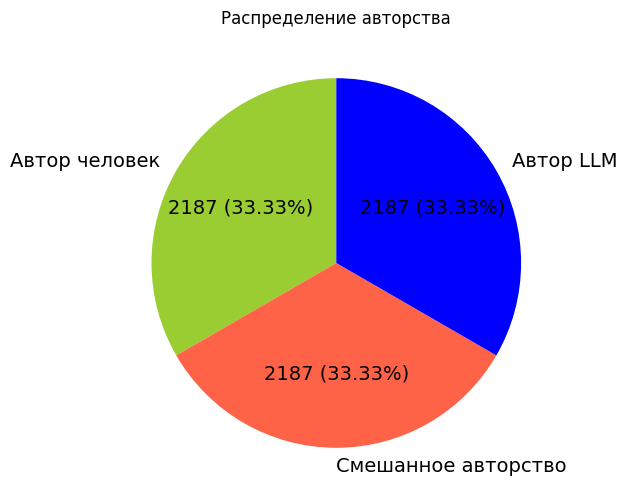

In [17]:
human_output_count = df.loc[df['variable'] == 'human_output'].shape[0]
human_edits_count = df.loc[df['variable'] == 'human_edits'].shape[0]
model_output_count = df.loc[df['variable'] == 'model_output'].shape[0]

counts = [human_output_count, human_edits_count, model_output_count]
plt.figure(figsize=(8, 6))
plt.pie(
    x=counts,
    labels=['Автор человек', 'Смешанное авторство', 'Автор LLM'],
    colors=['yellowgreen', 'tomato', 'blue'],
    autopct=lambda p: f'{int(p * sum(counts) / 100)} ({p:.2f}%)', startangle=90, 
    textprops={'fontsize': 14}
)
plt.title('Распределение авторства')
plt.show()

**Распределение количества слов и символов**

_Вывод._ Люди пишут более короткие предложения, чем LLM. Люди исправляют пунктуацию и перефразируют LLM, но уже не сокращают принципиально написанной моделью текст.

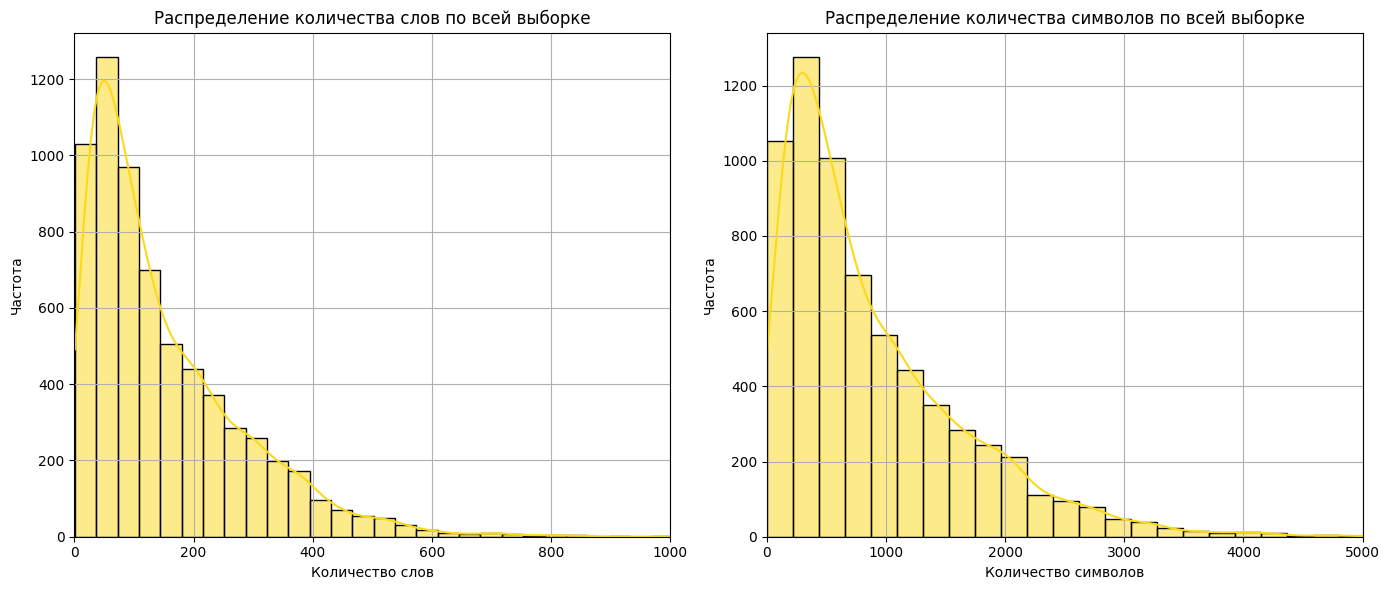

In [18]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

sns.histplot(df.value.str.split().str.len(), bins=30, color='#fcd918', kde=True)
plt.title('Распределение количества слов по всей выборке')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 1000)
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(df.value.str.len(), bins=30, color='#fcd918', kde=True)
plt.title('Распределение количества символов по всей выборке')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 5000)
plt.grid()

plt.tight_layout()
plt.show()

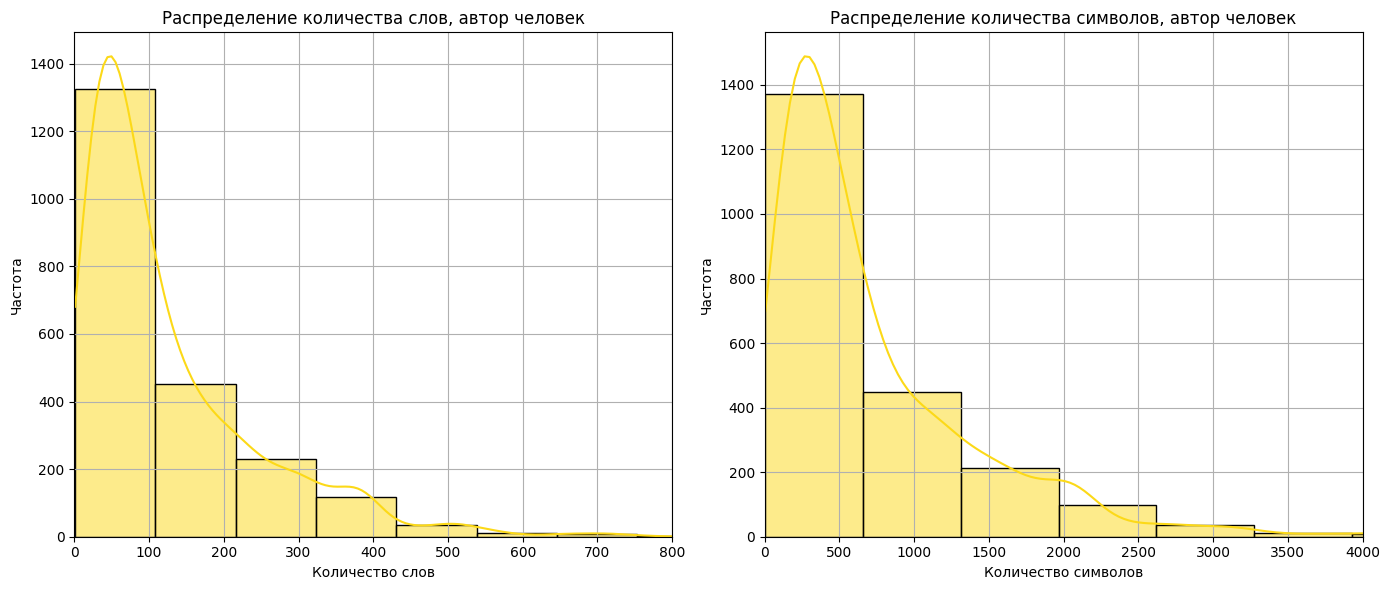

In [19]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

sns.histplot(df.loc[df['variable'] == 'human_output'].value.str.split().str.len(), bins=10, color='#fcd918', kde=True)
plt.title('Распределение количества слов, автор человек')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 800)
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(df.loc[df['variable'] == 'human_output'].value.str.len(), bins=10, color='#fcd918', kde=True)
plt.title('Распределение количества символов, автор человек')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 4000)
plt.grid()

plt.tight_layout()
plt.show()

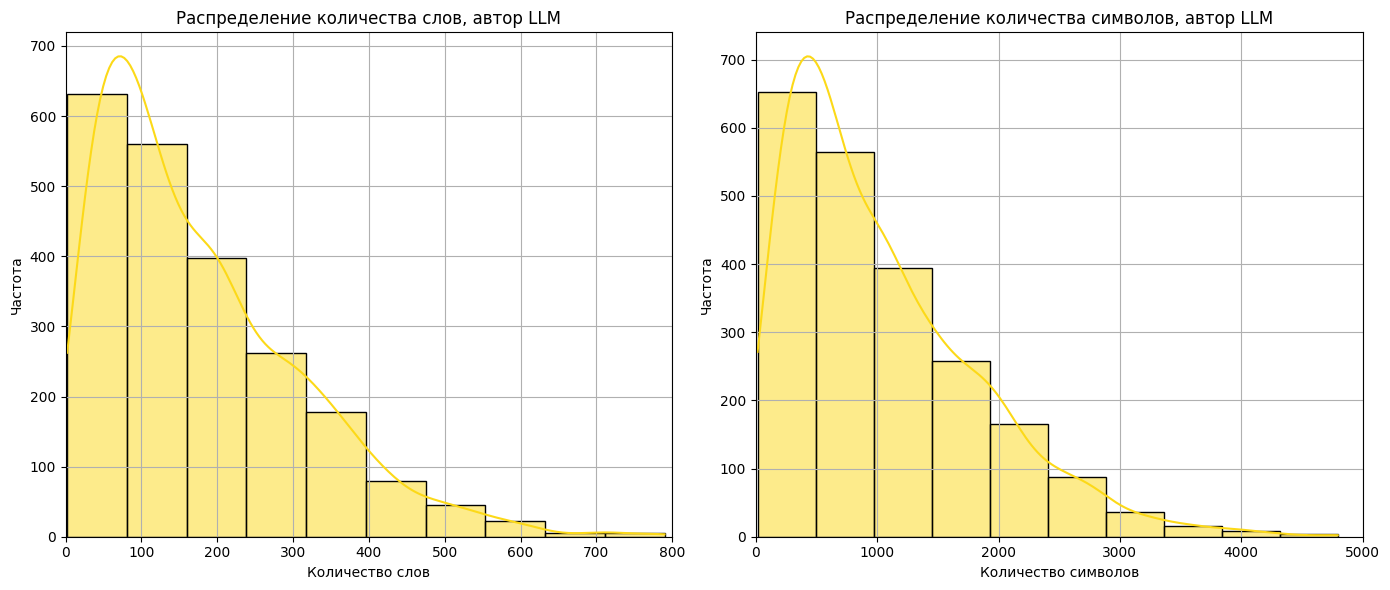

In [20]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

sns.histplot(df.loc[df['variable'] == 'model_output'].value.str.split().str.len(), bins=10, color='#fcd918', kde=True)
plt.title('Распределение количества слов, автор LLM')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 800)
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(df.loc[df['variable'] == 'model_output'].value.str.len(), bins=10, color='#fcd918', kde=True)
plt.title('Распределение количества символов, автор LLM')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 5000)
plt.grid()

plt.tight_layout()
plt.show()

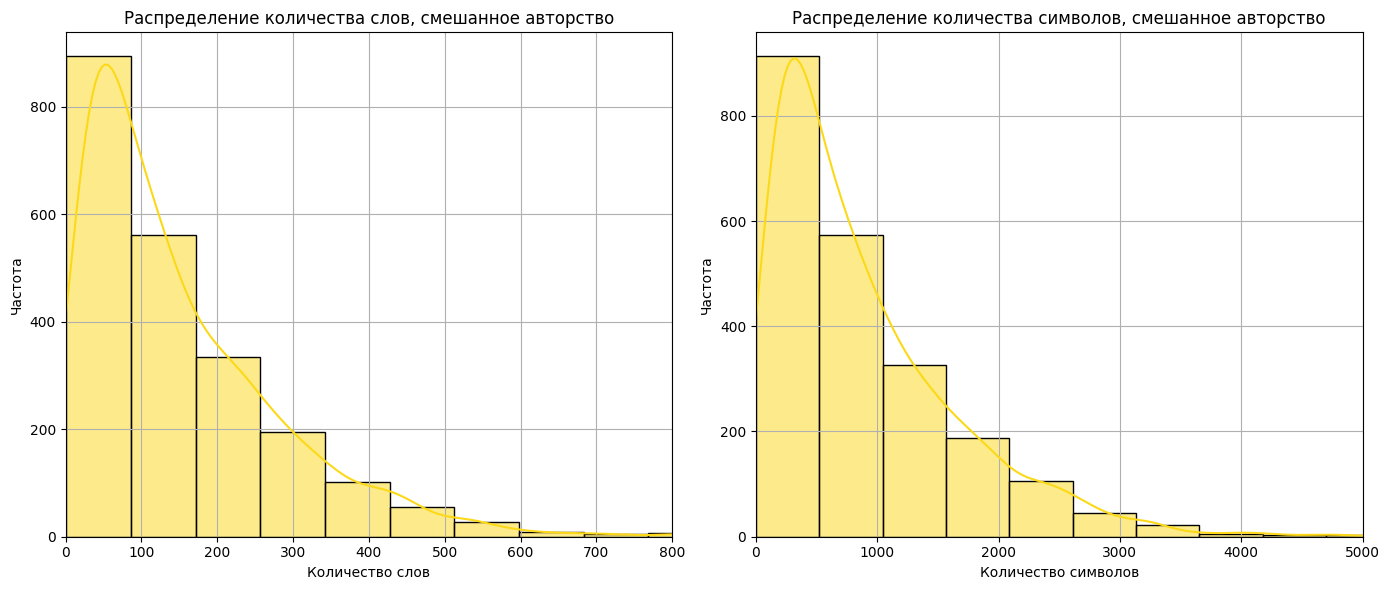

In [21]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

sns.histplot(df.loc[df['variable'] == 'human_edits'].value.str.split().str.len(), bins=10, color='#fcd918', kde=True)
plt.title('Распределение количества слов, смешанное авторство')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 800)
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(df.loc[df['variable'] == 'human_edits'].value.str.len(), bins=10, color='#fcd918', kde=True)
plt.title('Распределение количества символов, смешанное авторство')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 5000)
plt.grid()

plt.tight_layout()
plt.show()

**Распределение максимальной и минимальной длины текстов**

_Вывод._ Человек пишет в среднем гораздо короче, чем LLM. При смешанном авторстве длинный текст LLM чуть сокращается, но не до уровня человеческого текста. При этом самые длинные по выборке тексты написал именно человек. Также видим, что LLM заметно чаще использует символ `*`. Это связано с Markdown-синтаксисом. Человек это подчищает.

In [22]:
df_char_count = pd.DataFrame({
    'char_count': df.value.str.len(),
    'char_count_human': df.loc[df['variable'] == 'human_output'].value.str.len().reset_index(drop=True),
    'char_count_llm': df.loc[df['variable'] == 'model_output'].value.str.len().reset_index(drop=True),
    'char_count_mixed': df.loc[df['variable'] == 'human_edits'].value.str.len().reset_index(drop=True)
})

descriptive_stats = df_char_count.describe().loc[['min', 'mean', 'max']].values.T

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45648/3881487458.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(data,


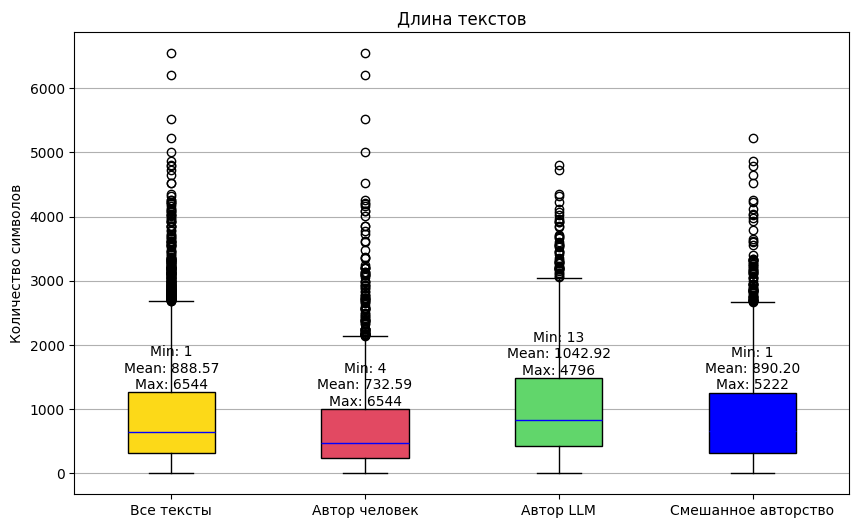

In [23]:
#Данные для boxplot'ов
data = [
    df.value.str.len(),
    df.loc[df['variable'] == 'human_output'].value.str.len(),
    df.loc[df['variable'] == 'model_output'].value.str.len(),
    df.loc[df['variable'] == 'human_edits'].value.str.len()
]

plt.figure(figsize=(10, 6))
bplot = plt.boxplot(data,
                    labels=['Все тексты', 'Автор человек', 'Автор LLM', 'Смешанное авторство'],
                    vert=True,
                    patch_artist=True)

#Цвета для ящиков с усами
bplot['boxes'][0].set_facecolor('#fcd918')
bplot['boxes'][1].set_facecolor('#e24962')
bplot['boxes'][2].set_facecolor('#61d66b')
bplot['boxes'][3].set_facecolor('#0000FF')

#Цвет медианы
for median in bplot['medians']:
    median.set_color('blue')

for i, box in enumerate(bplot['boxes']):
    bbox = box.get_path().get_extents()
    x = bbox.x0 + (bbox.x1 - bbox.x0) / 2
    y = bbox.y1 + 8
    plt.text(x, y, f"Min: {descriptive_stats[i,0]:.0f}\nMean: {descriptive_stats[i,1]:.2f}\nMax: {descriptive_stats[i,2]:.0f}", ha='center', va='bottom')


plt.title('Длина текстов')
plt.ylabel('Количество символов')
plt.grid(axis='y')
plt.show()

**Анализ пунктуации**

_Вывод._ В основном во всех текстах используются точки запятые, апострофы `'` (почему-то). LLM очень любит запятые — длинные сложносочиненные предложения. Люди разбивают тексты на короткие предложения. При редактировании текста LLM число запятых снижается, число точек увеличивается — сложные предложения разбиваются на несколько простых.

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\!'
<>:11: SyntaxWarning: invalid escape sequence '\,'
<>:12: SyntaxWarning: invalid escape sequence '\/'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\!'
<>:11: SyntaxWarning: invalid escape sequence '\,'
<>:12: SyntaxWarning: invalid escape sequence '\/'
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45648/143003259.py:7: SyntaxWarning: invalid escape sequence '\.'
  df['._count'] = df.value.str.count('\.')
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45648/143003259.py:8: SyntaxWarning: invalid escape sequence '\!'
  df['!_count'] = df.value.str.count('\!')
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45648/143003259.py:11: SyntaxWarning: invalid escape sequence '\,'
  df[',_count'] = df.value.str.count('\,')
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45648/143003259.py:12: SyntaxWar

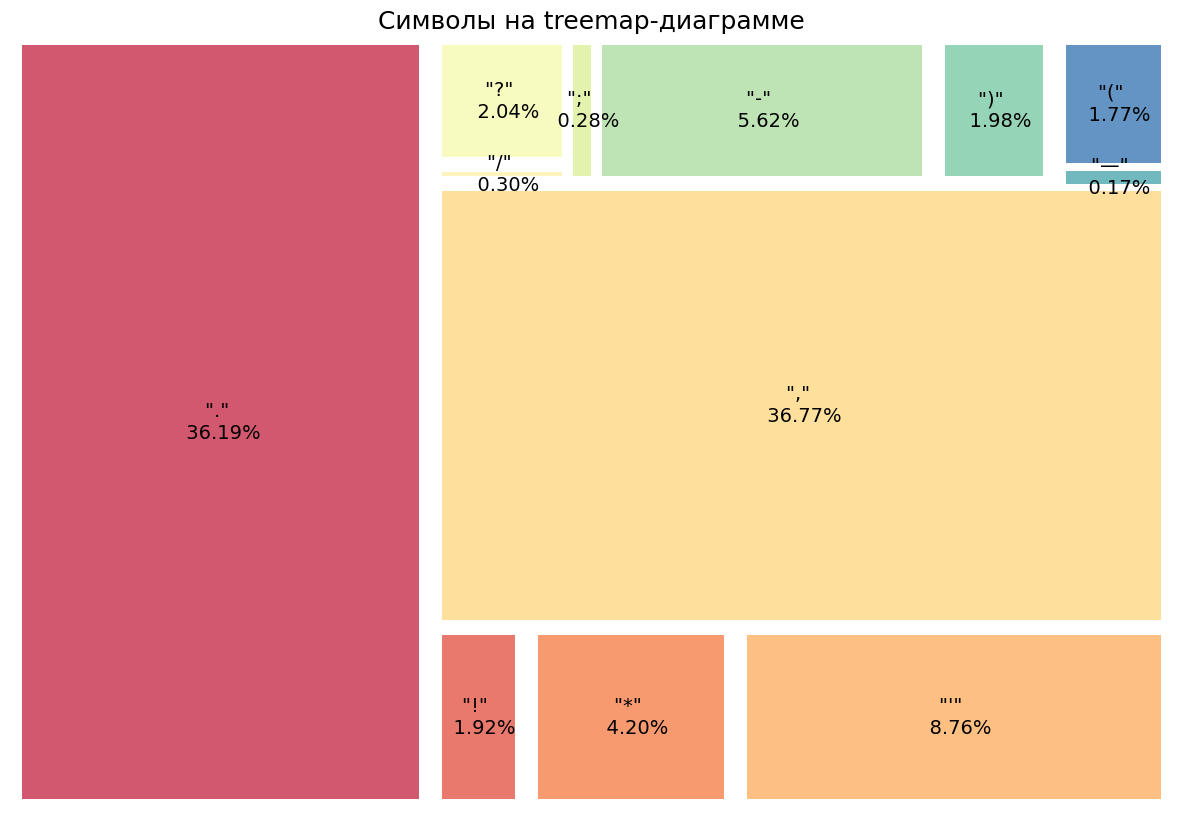

In [25]:
joined_text = ''.join(df.value.tolist())
pattern_for_text = r'[a-zâÂãÃA-Z0-9\s]+'
result = re.sub(pattern_for_text, '', joined_text)
c = Counter(result)
c.most_common(15)

df['._count'] = df.value.str.count('\.')
df['!_count'] = df.value.str.count('\!')
df['*_count'] = df.value.str.count(r'\*')
df["'_count"] = df.value.str.count('\'')
df[',_count'] = df.value.str.count('\,')
df['/_count'] = df.value.str.count('\/')
df['?_count'] = df.value.str.count(r'\?')
df[';_count'] = df.value.str.count(r'\;')
df['-_count'] = df.value.str.count(r'\-')
df[')_count'] = df.value.str.count(r'\)')
df['—_count'] = df.value.str.count(r'\—')
df['(_count'] = df.value.str.count(r'\(')

colors = ['lightcoral', 'khaki', 'sandybrown', 'navajowhite', 'plum', 'palegreen', 'mediumaquamarine', 'lightblue', 'mediumpurple', 'orchid', 'pink', 'crimson']

labels = ['.', '!', '*', "'", ',', '/', '?', ';', '-', ')', '—', '(']

summary_all = df.agg({
    '._count': 'sum',
    '!_count': 'sum',
    '*_count': 'sum',
    "'_count": 'sum',
    ",_count": 'sum',
    '/_count': 'sum',
    '?_count': 'sum',
    ';_count': 'sum',
    '-_count': 'sum',
    ')_count': 'sum',
    '—_count': 'sum',
    '(_count': 'sum',
})

perc = [f'{i/sum(summary_all.values.tolist())*100:5.2f}%' for i in summary_all.values.tolist()]
lbl = [f'"{el[0]}" \n {el[1]}' for el in zip(labels, perc)]

plt.figure(figsize=(15, 10))
axis = squarify.plot(sizes=summary_all.values.tolist(), label=lbl, pad=1, alpha=0.8, color=sns.color_palette('Spectral',len(labels)), text_kwargs={'fontsize': 14})
axis.set_title('Символы на treemap-диаграмме', fontsize=18)
plt.axis('off')
plt.show()

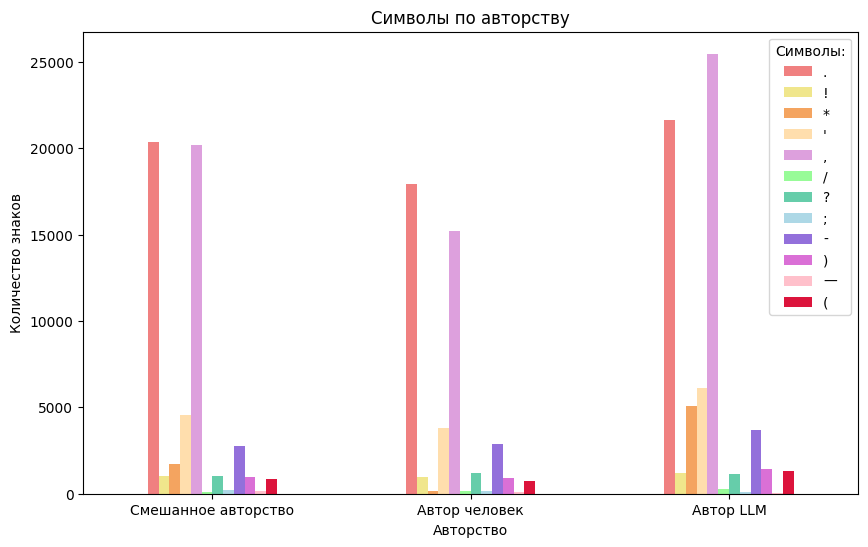

In [26]:
summary = df.groupby('variable').agg({
    '._count': 'sum',
    '!_count': 'sum',
    '*_count': 'sum',
    "'_count": 'sum',
    ",_count": 'sum',
    '/_count': 'sum',
    '?_count': 'sum',
    ';_count': 'sum',
    '-_count': 'sum',
    ')_count': 'sum',
    '—_count': 'sum',
    '(_count': 'sum',
}).reset_index()

summary = summary.rename(index={0:'Смешанное авторство', 1:'Автор человек', 2: 'Автор LLM'})

summary.drop('variable', axis=1).plot(kind="bar", figsize=(10,6), rot=0, color=colors)
plt.title('Символы по авторству')
plt.legend(labels, title="Символы:")
plt.ylabel('Количество знаков')
plt.xlabel('Авторство')
plt.show()

**Обработка текста на основе EDA**

Промежуточная часть для следующих разделов.

In [27]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

In [28]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
df['cleaned_value'] = df.value.str.replace(r"[^a-zA-Z\s']", '', regex=True)

In [31]:
df['tokens'] = df.cleaned_value.apply(word_tokenize)

In [32]:
df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

In [33]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

**Распределение частей речи**

_Вывод._ Принципиальных различий не выявлено, здесь тексты, написанные LLM и человеком, мало чем отличаются.

In [34]:
# !python -m spacy download en

In [35]:
%%time

nlp = spacy.load(
    "en_core_web_sm",
    disable=['parser', 'senter', 'ner', 'lemmatizer'],
    enable=['tok2vec', 'tagger', 'attribute_ruler']
)
df['spacy_lemmatized'] = df.lemmatized.str.join(' ').apply(lambda x : nlp(x))

CPU times: user 1min 6s, sys: 188 ms, total: 1min 6s
Wall time: 1min 6s


In [36]:
%%time

def spacy_lemmatize_tokens(text):
    c = []
    doc = nlp(text)
    k = [(token.text, token.pos_) for token in doc]
    c.extend(k)
    return c

df['lemmatized_pronouns'] = df['spacy_lemmatized'].apply(spacy_lemmatize_tokens)

CPU times: user 1min 4s, sys: 364 ms, total: 1min 4s
Wall time: 1min 5s


In [37]:
df['pos_tags'] = df['lemmatized_pronouns']

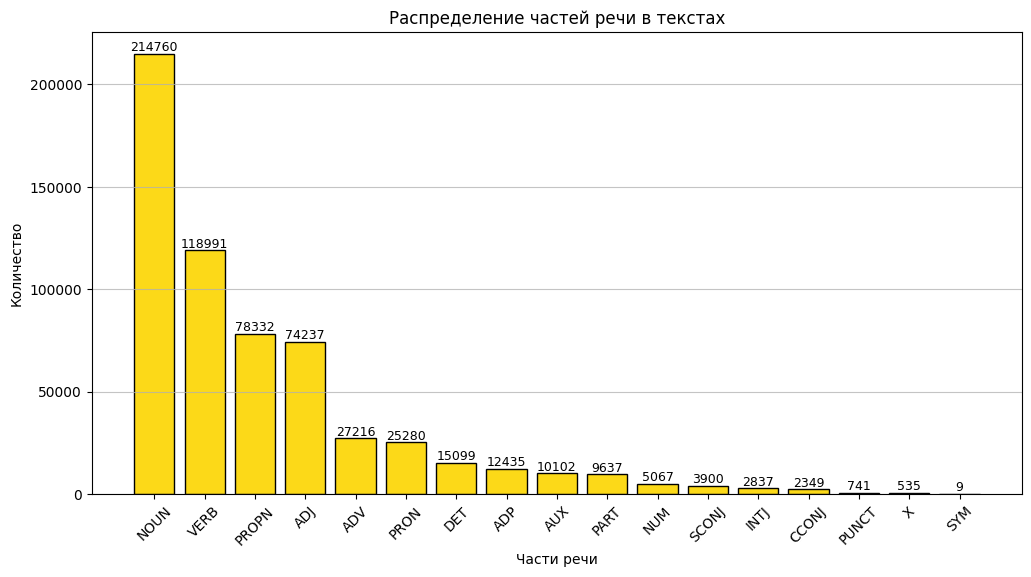

In [38]:
pos_counts = Counter()
for tags in df['pos_tags']:
    pos_counts.update(tag for word, tag in tags)

df_pos = pd.DataFrame(pos_counts.items(), columns=['Part of Speech', 'Count'])
df_pos = df_pos.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bars = plt.bar(df_pos['Part of Speech'], df_pos['Count'], color='#fcd918', edgecolor='black')
plt.title('Распределение частей речи в текстах')
plt.xlabel('Части речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(height), ha='center', va='bottom', fontsize=9)

plt.show()

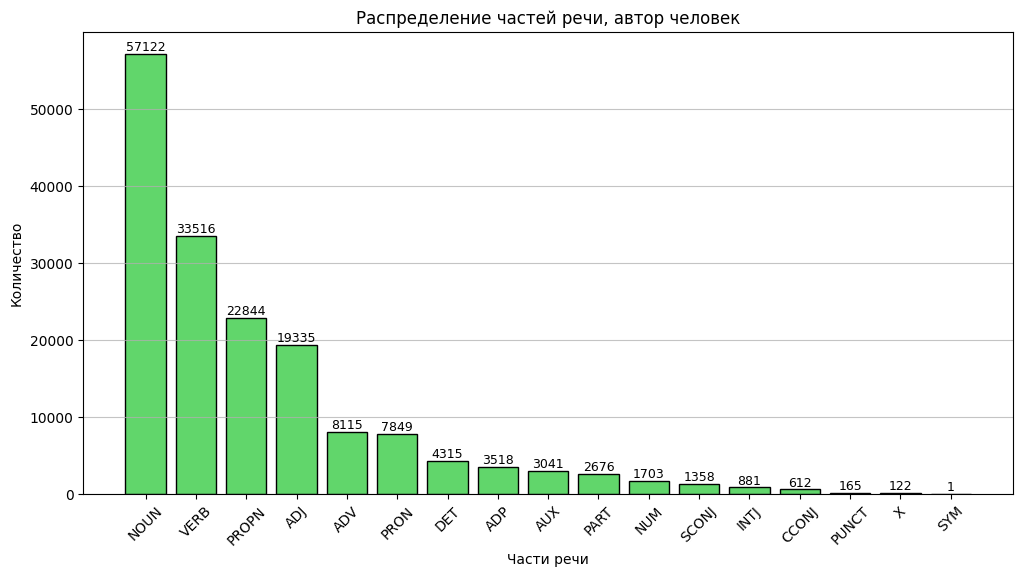

In [39]:
df_pos = df.loc[df['variable'] == 'human_output']

pos_counts_pos = Counter()
for tags in df_pos['pos_tags']:
    pos_counts_pos.update(tag for word, tag in tags)

df_pos_cur_author = pd.DataFrame(pos_counts_pos.items(), columns=['Part of Speech', 'Count'])
df_pos_cur_author = df_pos_cur_author.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bars = plt.bar(df_pos_cur_author['Part of Speech'], df_pos_cur_author['Count'], color='#61d66b', edgecolor='black')
plt.title('Распределение частей речи, автор человек')
plt.xlabel('Части речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(height), ha='center', va='bottom', fontsize=9)

plt.show()

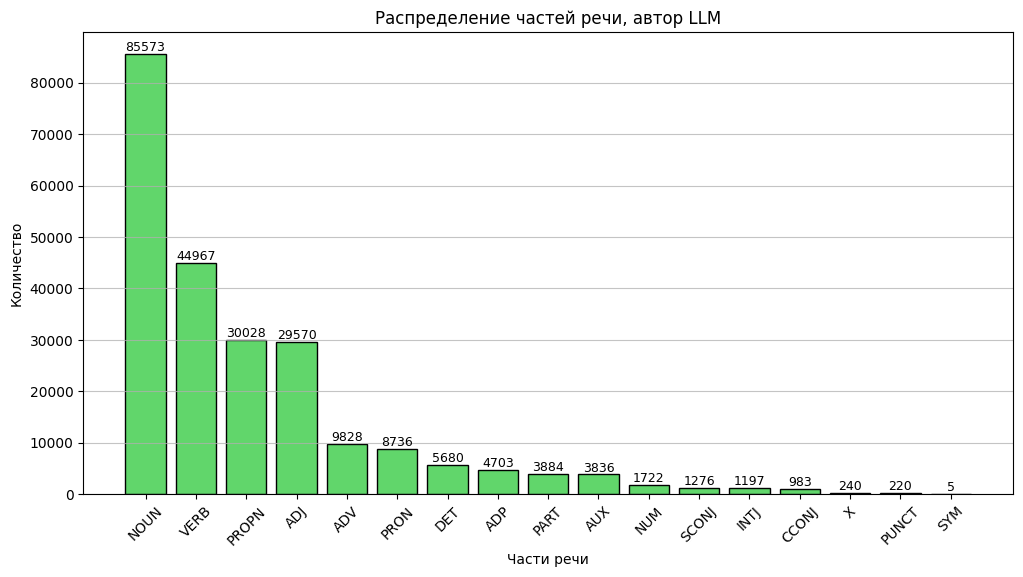

In [40]:
df_pos = df.loc[df['variable'] == 'model_output']

pos_counts_pos = Counter()
for tags in df_pos['pos_tags']:
    pos_counts_pos.update(tag for word, tag in tags)

df_pos_cur_author = pd.DataFrame(pos_counts_pos.items(), columns=['Part of Speech', 'Count'])
df_pos_cur_author = df_pos_cur_author.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bars = plt.bar(df_pos_cur_author['Part of Speech'], df_pos_cur_author['Count'], color='#61d66b', edgecolor='black')
plt.title('Распределение частей речи, автор LLM')
plt.xlabel('Части речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(height), ha='center', va='bottom', fontsize=9)

plt.show()

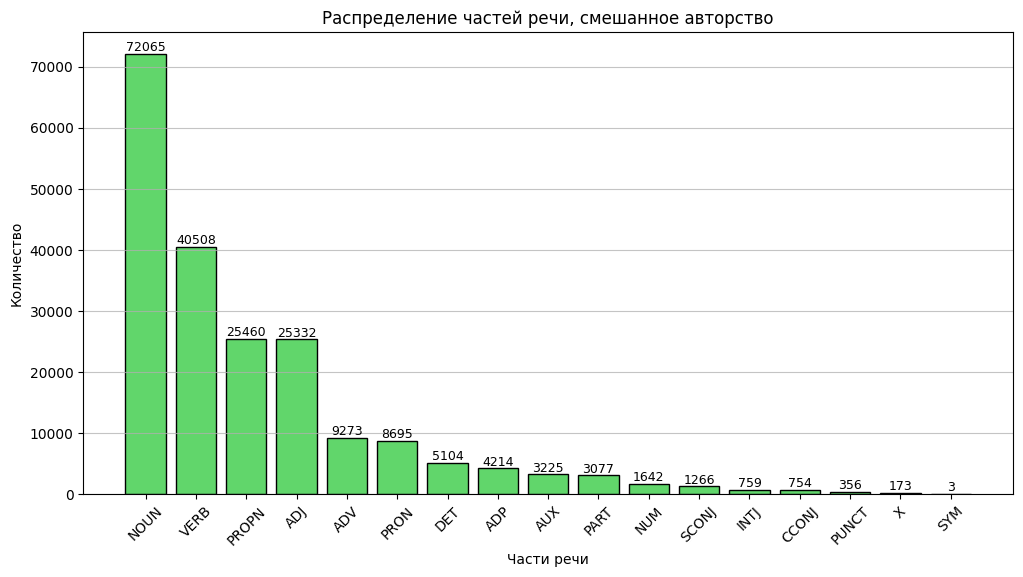

In [41]:
df_pos = df.loc[df['variable'] == 'human_edits']

pos_counts_pos = Counter()
for tags in df_pos['pos_tags']:
    pos_counts_pos.update(tag for word, tag in tags)

df_pos_cur_author = pd.DataFrame(pos_counts_pos.items(), columns=['Part of Speech', 'Count'])
df_pos_cur_author = df_pos_cur_author.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
bars = plt.bar(df_pos_cur_author['Part of Speech'], df_pos_cur_author['Count'], color='#61d66b', edgecolor='black')
plt.title('Распределение частей речи, смешанное авторство')
plt.xlabel('Части речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(height), ha='center', va='bottom', fontsize=9)

plt.show()

**Облака слов**

_Вывод._ Облака слов отличаются, но не сильно. Состав слов у текста, написанного LLM, и текста после редактуры принципиально не меняется. А человек пишет немного по-другому.

In [42]:
df['lemmatized_str'] = df['lemmatized'].apply(lambda x: ' '.join(x))

In [43]:
author_human = ' '.join(df.loc[df['variable'] == 'human_output', 'lemmatized_str'])
author_llm = ' '.join(df.loc[df['variable'] == 'model_output', 'lemmatized_str'])
author_mixed = ' '.join(df.loc[df['variable'] == 'human_edits', 'lemmatized_str'])

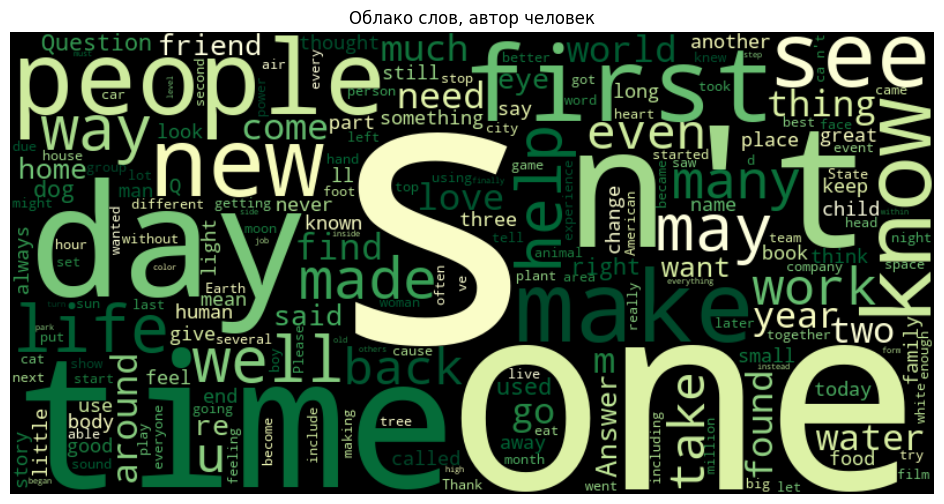

In [44]:
wordcloud_pos = WordCloud(width=800, height=400, colormap='YlGn', background_color='black').generate(author_human)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов, автор человек')
plt.show()

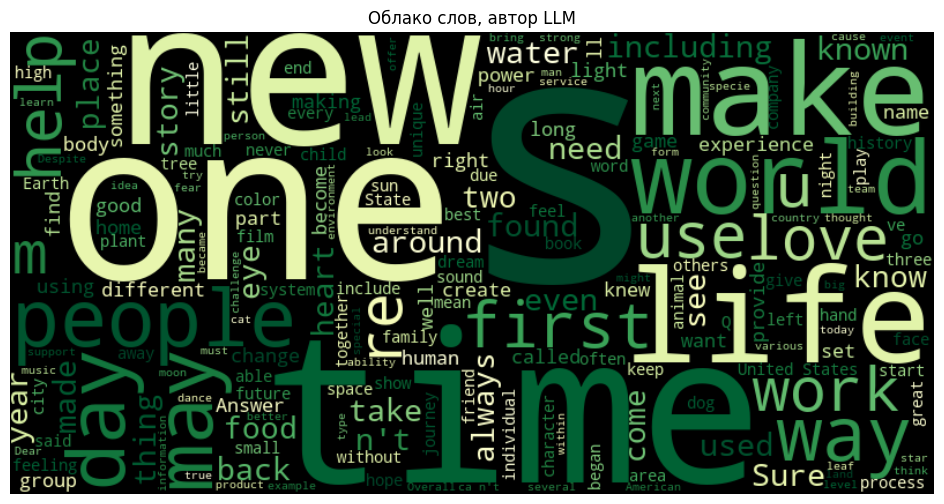

In [45]:
wordcloud_pos = WordCloud(width=800, height=400, colormap='YlGn', background_color='black').generate(author_llm)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов, автор LLM')
plt.show()

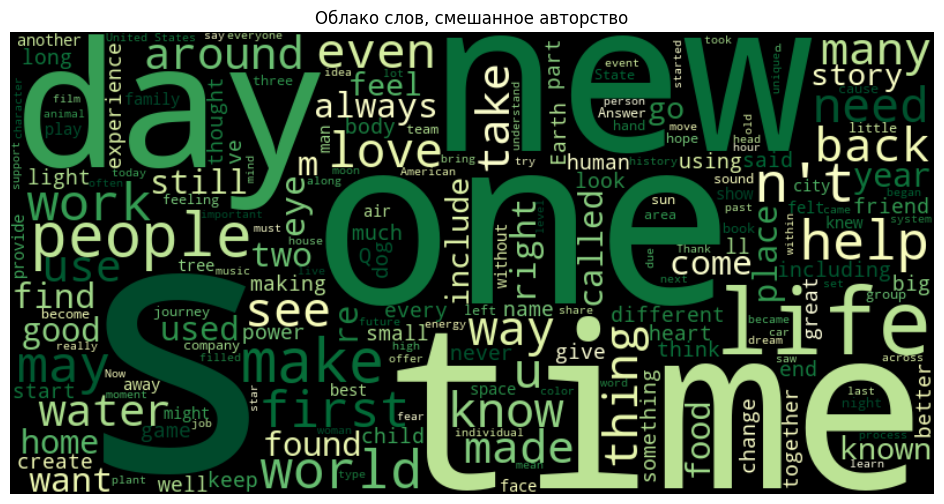

In [46]:
wordcloud_pos = WordCloud(width=800, height=400, colormap='YlGn', background_color='black').generate(author_mixed)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов, смешанное авторство')
plt.show()

**Топ-20 слов**

_Вывод._ Дополнительно подтвердился вывод из предыдущего пункта. При этом выглядит все так, будто LLM все-таки не использует меньше сокращений (к примеру, токен `n't`). В то же время корректное сравнение тут невозможно, тк модели разные.

In [47]:
dict_human = {}
for text in df.loc[df['variable'] == 'human_output', 'lemmatized_str']:
    words = text.split()
    for word in words:
        if word in dict_human:
            dict_human[word] += 1
        else:
            dict_human[word] = 1

dict_llm = {}
for text in df.loc[df['variable'] == 'model_output', 'lemmatized_str']:
    words = text.split()
    for word in words:
        if word in dict_llm:
            dict_llm[word] += 1
        else:
            dict_llm[word] = 1

dict_mixed = {}
for text in df.loc[df['variable'] == 'human_edits', 'lemmatized_str']:
    words = text.split()
    for word in words:
        if word in dict_mixed:
            dict_mixed[word] += 1
        else:
            dict_mixed[word] = 1

In [48]:
df_dict_human = pd.DataFrame(list(dict_human.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')
df_dict_llm = pd.DataFrame(list(dict_llm.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')
df_dict_mixed = pd.DataFrame(list(dict_mixed.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')

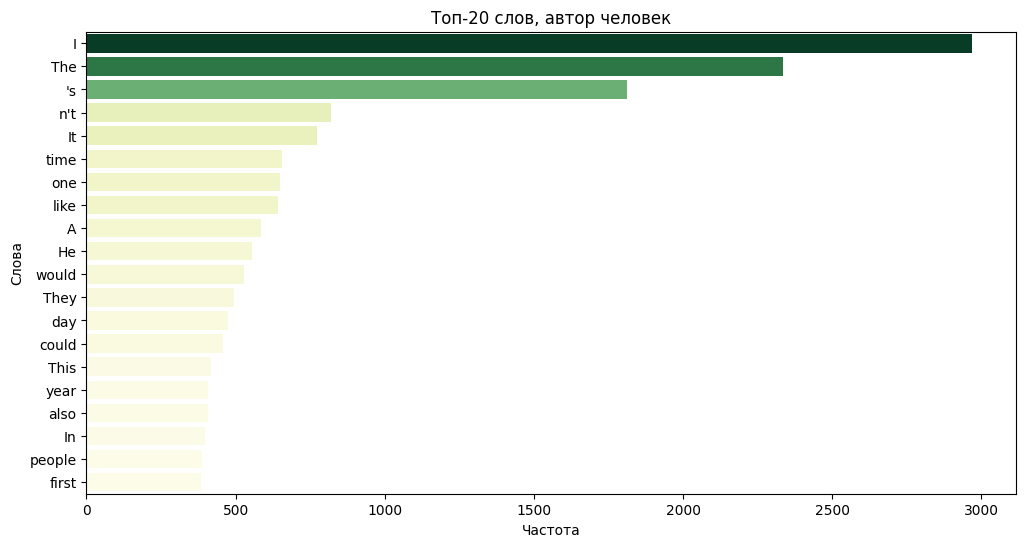

In [49]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_human, palette='YlGn', legend=False)
plt.title('Топ-20 слов, автор человек')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

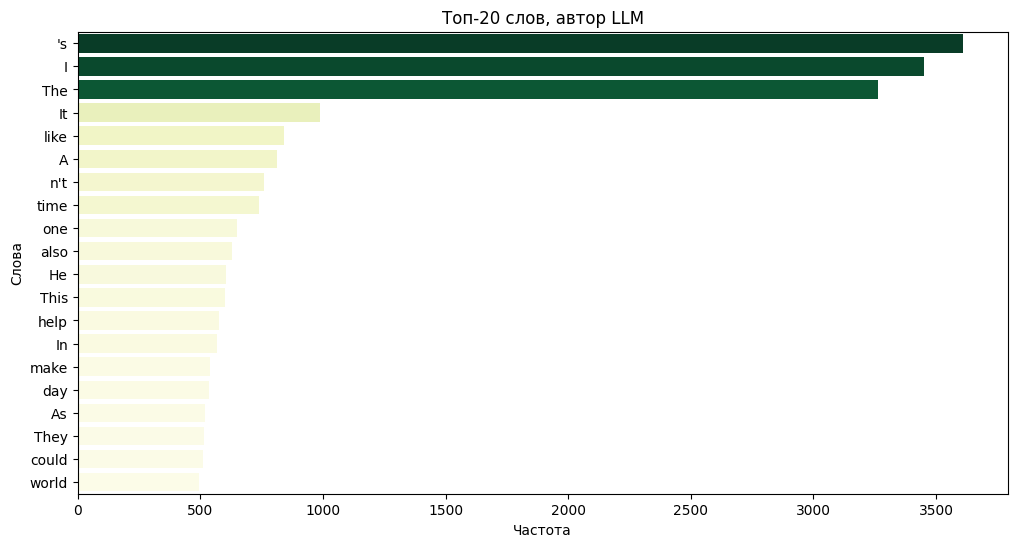

In [50]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_llm, palette='YlGn', legend=False)
plt.title('Топ-20 слов, автор LLM')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

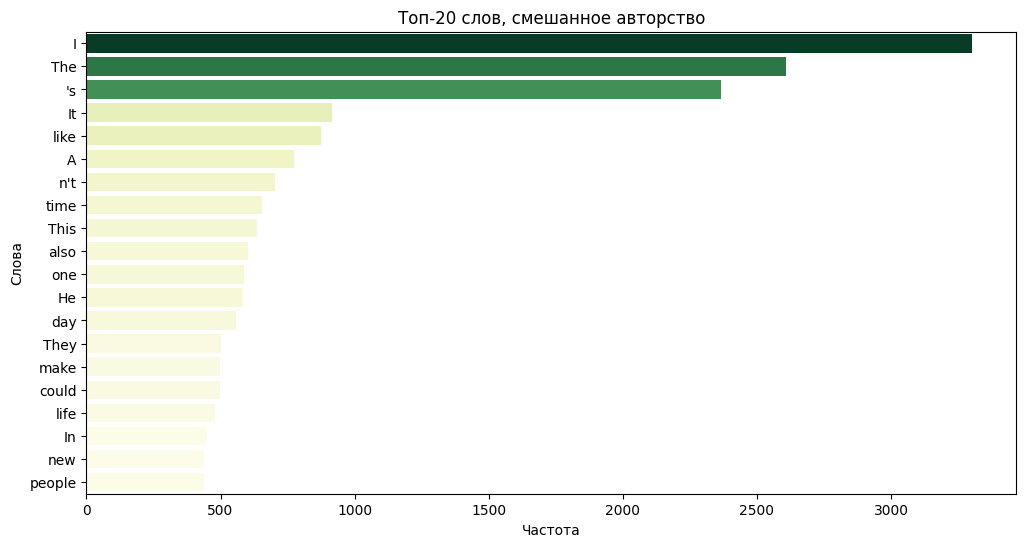

In [51]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_mixed, palette='YlGn', legend=False)
plt.title('Топ-20 слов, смешанное авторство')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

**Анализ пересечений для `mixed` и `llm` + топ-20 слов после удаления + облако слов**

In [52]:
top_20_human = df_dict_human['word'].tolist()
top_20_llm = df_dict_llm['word'].tolist()
top_20_mixed = df_dict_mixed['word'].tolist()

In [53]:
common_words = list(set(top_20_llm) & set(top_20_mixed))

results_df = pd.DataFrame(columns=['word', 'llm_rank', 'mixed_rank'])

for word in common_words:
    llm_rank = top_20_llm.index(word) + 1 if word in top_20_llm else None
    mixed_rank = top_20_mixed.index(word) + 1 if word in top_20_mixed else None
    results_df = pd.concat(
        [results_df, pd.DataFrame({'word': [word], 'llm_rank': [llm_rank], 'mixed_rank': [mixed_rank]})],
        ignore_index=True
    )

results_df

,word,llm_rank,mixed_rank
0,In,14,18
1,The,3,2
2,I,2,1
3,time,8,8
4,n't,7,7
5,He,11,12
6,day,16,13
7,'s,1,3
8,like,5,5
9,also,10,10


In [54]:
words_to_remove = ['This',
 'life',
 'like',
 'day',
 'The',
 'also',
 'I',
 'one',
 'In',
 'He',
 'It',
 'make',
 'time',
 'A',
 'new']  # удаляем все с похожим рангом

def remove_words_from_dict(input_dict, words_to_remove):
    return {k: v for k, v in input_dict.items() if k not in words_to_remove}

In [55]:
dict_llm_cleaned = remove_words_from_dict(dict_llm, words_to_remove)
dict_mixed_cleaned = remove_words_from_dict(dict_mixed, words_to_remove)

In [56]:
df_dict_llm_cleaned = pd.DataFrame(list(dict_llm_cleaned.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')
df_dict_mixed_cleaned = pd.DataFrame(list(dict_mixed_cleaned.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')

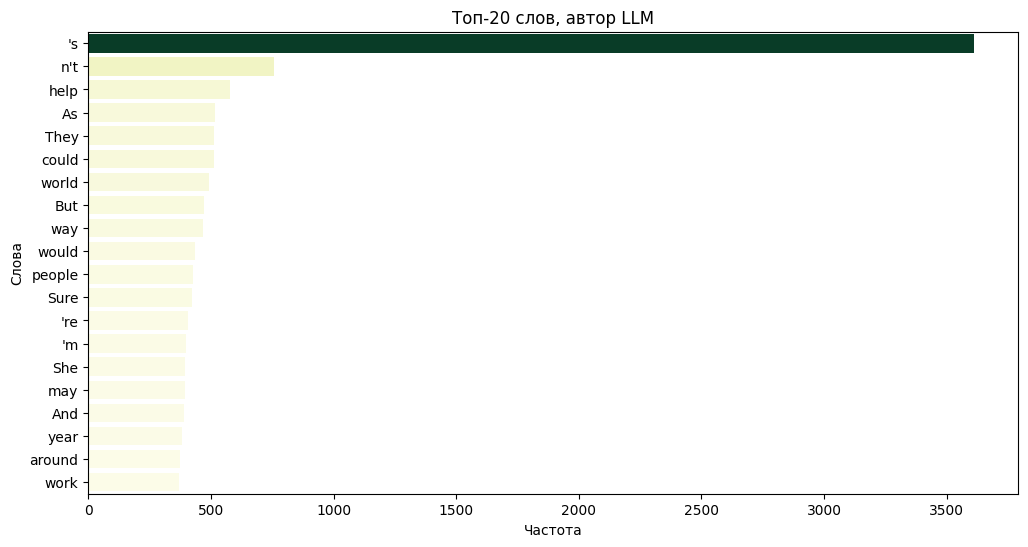

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_llm_cleaned, palette='YlGn', legend=False)
plt.title('Топ-20 слов, автор LLM')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

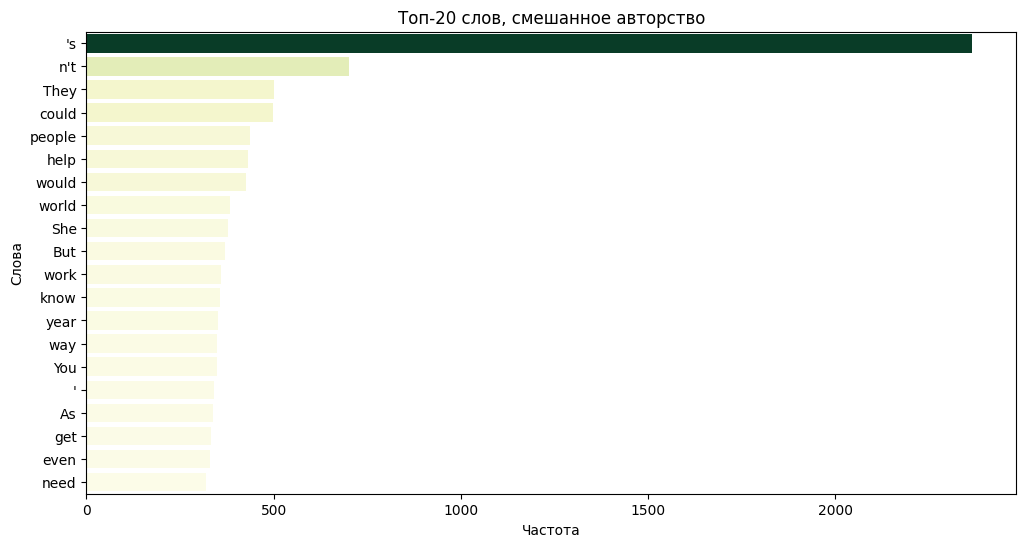

In [58]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_mixed_cleaned, palette='YlGn', legend=False)
plt.title('Топ-20 слов, смешанное авторство')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

**Анализ пересечений для `human` и `llm` + топ-20 слов после удаления + облако слов**

In [59]:
top_20_human = df_dict_human['word'].tolist()
top_20_llm = df_dict_llm['word'].tolist()
top_20_mixed = df_dict_mixed['word'].tolist()

In [60]:
common_words = list(set(top_20_llm) & set(top_20_mixed))

results_df = pd.DataFrame(columns=['word', 'llm_rank', 'mixed_rank'])

for word in common_words:
    llm_rank = top_20_llm.index(word) + 1 if word in top_20_llm else None
    human_rank = top_20_human.index(word) + 1 if word in top_20_human else None
    results_df = pd.concat(
        [results_df, pd.DataFrame({'word': [word], 'llm_rank': [llm_rank], 'human_rank': [human_rank]})],
        ignore_index=True
    )

results_df

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_45648/144629431.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(


,word,llm_rank,mixed_rank,human_rank
0,In,14,NaN,18.0
1,The,3,NaN,2.0
2,I,2,NaN,1.0
3,time,8,NaN,6.0
4,n't,7,NaN,4.0
5,He,11,NaN,10.0
6,day,16,NaN,13.0
7,'s,1,NaN,3.0
8,like,5,NaN,8.0
9,also,10,NaN,17.0


In [61]:
words_to_remove = ['This',
 'like',
 'day',
 'The',
 'I',
 'one',
 'He',
 'It',
 'time',
 'A']  # удаляем все с похожим рангом

def remove_words_from_dict(input_dict, words_to_remove):
    return {k: v for k, v in input_dict.items() if k not in words_to_remove}

In [62]:
dict_llm_cleaned = remove_words_from_dict(dict_llm, words_to_remove)
dict_human_cleaned = remove_words_from_dict(dict_human, words_to_remove)

In [63]:
df_dict_llm_cleaned = pd.DataFrame(list(dict_llm_cleaned.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')
df_dict_human_cleaned = pd.DataFrame(list(dict_human_cleaned.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')

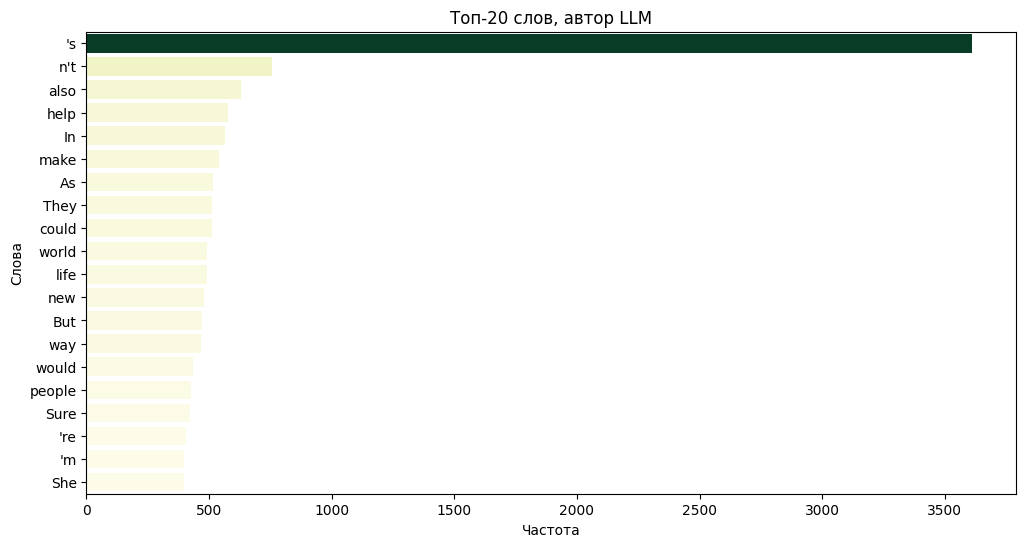

In [64]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_llm_cleaned, palette='YlGn', legend=False)
plt.title('Топ-20 слов, автор LLM')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

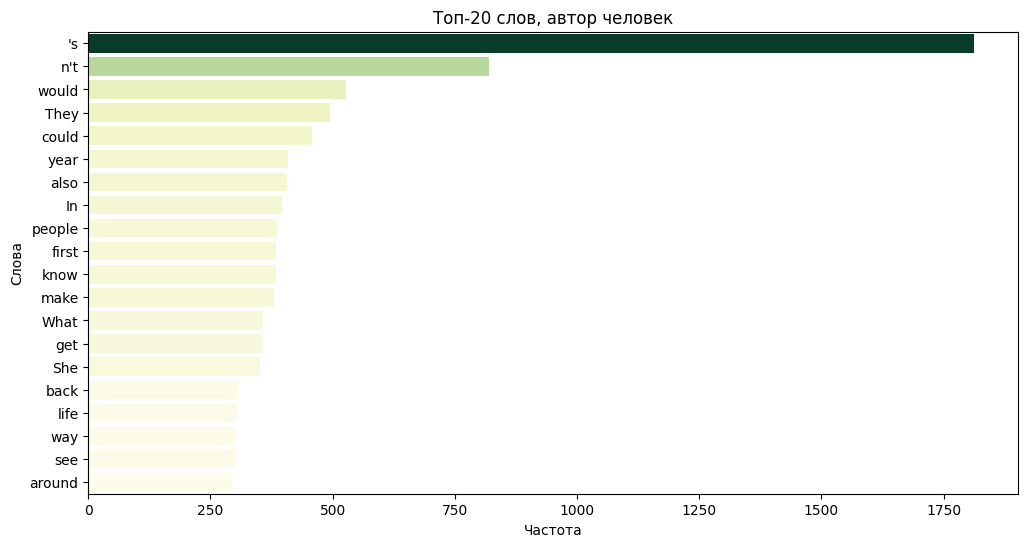

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_human_cleaned, palette='YlGn', legend=False)
plt.title('Топ-20 слов, автор человек')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

**Распределение $n$-грамм**

_Вывод._ По-моему, снова просто подтверждаем, что редактирование текста = убираем лишний синтаксис + разбиваем сложное на простое в основном.

In [66]:
bigrams_human = []
for text in df.loc[df['variable'] == 'human_output', 'lemmatized_str']:
    words = text.split()
    for bigram in ngrams(words, 2):
        bigrams_human.append(' '.join(bigram))

dict_bigram_human = {}
for bigram in bigrams_human:
    if bigram in dict_bigram_human:
        dict_bigram_human[bigram] += 1
    else:
        dict_bigram_human[bigram] = 1

In [67]:
bigrams_llm = []
for text in df.loc[df['variable'] == 'model_output', 'lemmatized_str']:
    words = text.split()
    for bigram in ngrams(words, 2):
        bigrams_llm.append(' '.join(bigram))

dict_bigram_llm = {}
for bigram in bigrams_llm:
    if bigram in dict_bigram_llm:
        dict_bigram_llm[bigram] += 1
    else:
        dict_bigram_llm[bigram] = 1

In [68]:
bigrams_mixed = []
for text in df.loc[df['variable'] == 'human_edits', 'lemmatized_str']:
    words = text.split()
    for bigram in ngrams(words, 2):
        bigrams_mixed.append(' '.join(bigram))

dict_bigram_mixed = {}
for bigram in bigrams_mixed:
    if bigram in dict_bigram_mixed:
        dict_bigram_mixed[bigram] += 1
    else:
        dict_bigram_mixed[bigram] = 1

In [69]:
df_bigram_human = pd.DataFrame(list(dict_bigram_human.items()), columns=['bigram', 'frequency']).nlargest(20, 'frequency')

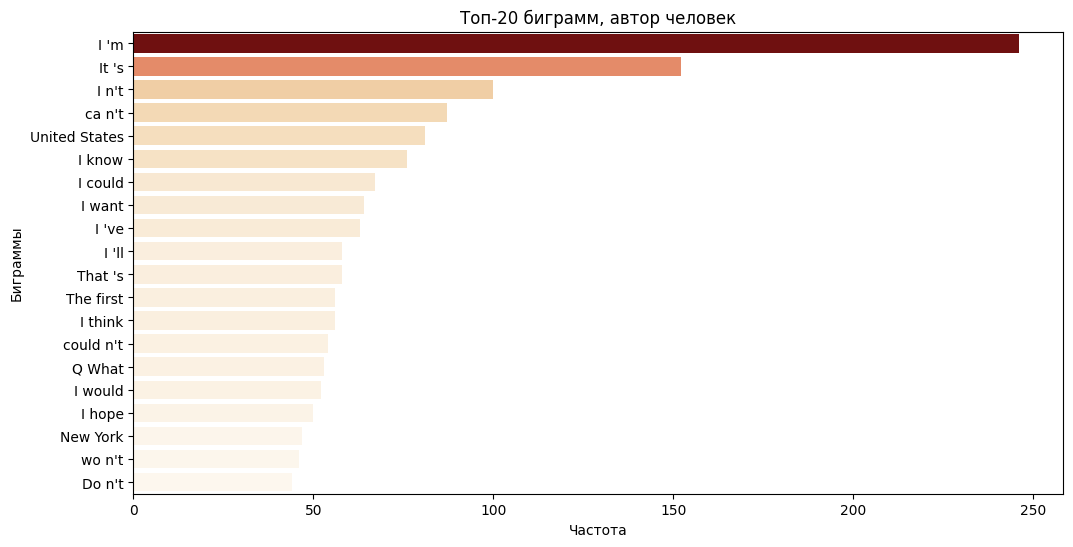

In [70]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='bigram', hue='frequency', data=df_bigram_human, palette='OrRd', legend=False)
plt.title('Топ-20 биграмм, автор человек')
plt.xlabel('Частота')
plt.ylabel('Биграммы')
plt.show()

In [71]:
df_bigram_llm = pd.DataFrame(list(dict_bigram_llm.items()), columns=['bigram', 'frequency']).nlargest(20, 'frequency')

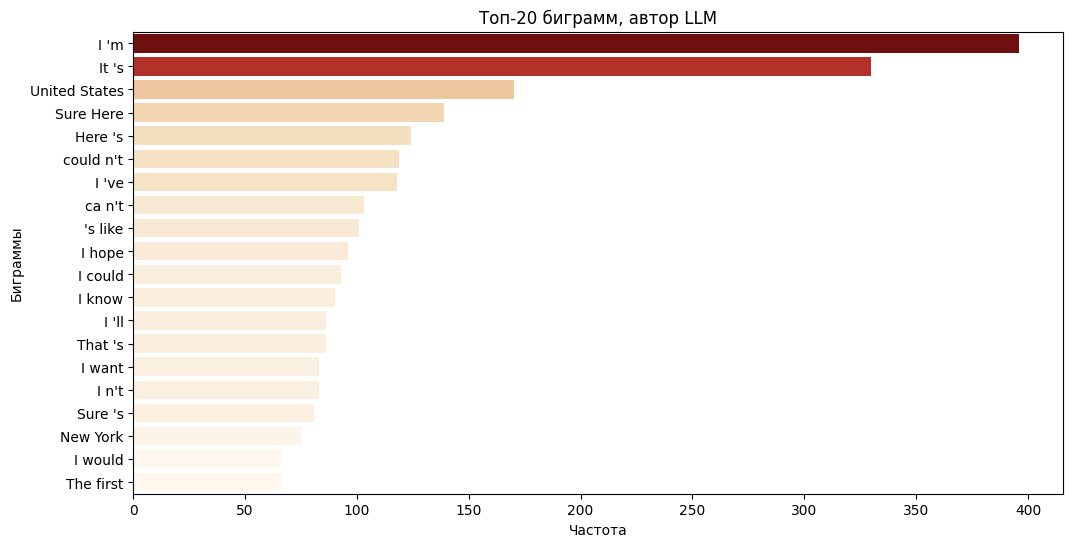

In [72]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='bigram', hue='frequency', data=df_bigram_llm, palette='OrRd', legend=False)
plt.title('Топ-20 биграмм, автор LLM')
plt.xlabel('Частота')
plt.ylabel('Биграммы')
plt.show()

In [73]:
df_bigram_mixed = pd.DataFrame(list(dict_bigram_mixed.items()), columns=['bigram', 'frequency']).nlargest(20, 'frequency')

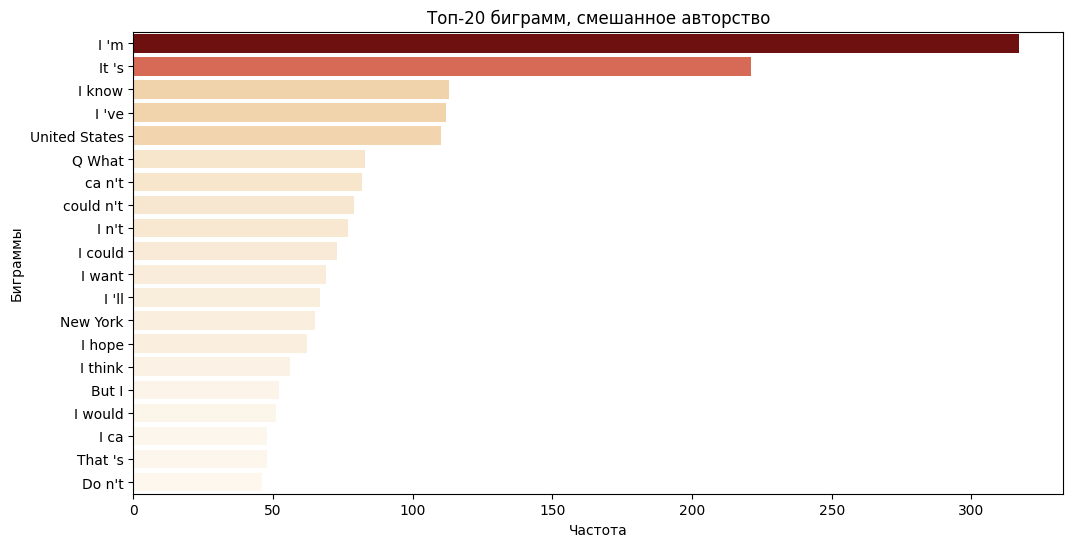

In [74]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='bigram', hue='frequency', data=df_bigram_mixed, palette='OrRd', legend=False)
plt.title('Топ-20 биграмм, смешанное авторство')
plt.xlabel('Частота')
plt.ylabel('Биграммы')
plt.show()

**Объяснение пересечений**

Все норм, но почему-то модель любит обороты вида `a diet / a method / etc can help ...`. Вроде все корректно и прям на одной какой-то теме оно не циклится.

In [125]:
weird_prompts_cond = (df.value.str.contains('help|life', regex=True)) & (df.variable == 'model_output')
weird_prompts = df.loc[weird_prompts_cond, 'prompt'].unique()

In [147]:
df.loc[df.prompt.isin(weird_prompts)].sort_values('prompt').iloc[-3].value

'As the stereotypical mafia boss sat in his opulent office, surrounded by his loyal minions, he couldn\'t help but reflect on the most important job he had ever had - being a father. Despite his tough exterior and rarely seen emotions, he knew that when it came to raising his children, he had always put family first.\n\n"I know that many of you out there think that being a parent is easy," he began, his voice low and measured. "But let me tell you, it\'s not. Raising a child takes a lot of hard work and dedication. It\'s not just about saying no and being strict, it\'s about teaching them the value of respect, loyalty, and family."\n\nHe paused, taking a drag on his cigar before continuing. "Now, I know some of you out there may think that the mafia lifestyle is not the best way to raise a child, but let me tell you, it\'s not just about the guns and the money. It\'s about teaching them the value of hard work and the importance of standing up for what they believe in."\n\n"When my chil

**Лексическое разнообразие**

Раз модель очень любит конкретные слова, это повод сравнить лексическое разнообразие по метрикам:
1. Perplexity: $\textrm{PPL}(P, Q) = 2^{\textrm{H}(P, Q)}$; чем выше, тем из большего числа слов модель выбирает для передачи нужного смысла; словарь разнообразнее, но уверенность ниже. Чем ниже, тем лучше.
2. N-gram разнообразие:
3. BLEU: сложная формула с Википедии про перекрытие $n$-грамм. Чем выше, тем лучше.
4. ROGE: Recall для $n$-грамм. Чем выше, тем лучше.

```
1111

# Source - https://stackoverflow.com/questions/54941966/how-can-i-calculate-perplexity-using-nltk
# Posted by mujjiga
# Retrieved 2026-01-26, License - CC BY-SA 4.0

import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Vocabulary

train_sentences = ['an apple', 'an orange']
tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) for sent in train_sentences]

n = 2
train_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
words = [word for sent in tokenized_text for word in sent]
words.extend(["<s>", "</s>"])
padded_vocab = Vocabulary(words)
model = MLE(n)
model.fit(train_data, padded_vocab)

test_sentences = ['an apple', 'an ant']
tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) for sent in test_sentences]

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
for test in test_data:
    print ("MLE Estimates:", [((ngram[-1], ngram[:-1]),model.score(ngram[-1], ngram[:-1])) for ngram in test])

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
for i, test in enumerate(test_data):
  print("PP({0}):{1}".format(test_sentences[i], model.perplexity(test)))


2222

https://pypi.org/project/diversity/

33333

# Importing evaluate library
import evaluate

# Load the BLEU and ROUGE metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Example sentences (non-tokenized)
reference = ["the cat is on the mat"]
candidate = ["the cat is on mat"]

# BLEU expects plain text inputs
bleu_results = bleu_metric.compute(predictions=candidate, references=reference)
print(f"BLEU Score: {bleu_results['bleu'] * 100:.2f}")

# ROUGE expects plain text inputs
rouge_results = rouge_metric.compute(predictions=candidate, references=reference)

# Access ROUGE scores (no need for indexing into the result)
print(f"ROUGE-1 F1 Score: {rouge_results['rouge1']:.2f}")
print(f"ROUGE-L F1 Score: {rouge_results['rougeL']:.2f}")
```